In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage
import webbrowser
from rdkit.Chem import AllChem
import py3Dmol


warnings.filterwarnings("ignore")
RDLogger.DisableLog("rdApp.*")

np.random.seed(42)
tf.random.set_seed(42)
import plotly.graph_objs as go
import numpy as np

In [2]:
df = pd.read_csv('../data/BBBP.csv')
df.head()

,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


In [3]:
def distribution_plot(input_data: np.ndarray, label: str, title: str) -> None:
    """
    Generate a histogram to visualize the distribution of the input data.

    Parameters:
    input_data (np.ndarray): The input data to be visualized.
    label (str): Label for the x-axis.
    title (str): Title of the plot.

    Returns:
    None: Displays the generated plot using Plotly.
    """
    fig = go.Figure()
    fig.add_trace(go.Histogram(x=input_data, name=label))
    fig.update_layout(
        title_text=title,
        xaxis_title_text=label,
        yaxis_title_text='Count',
        bargap=0.2
    )
    fig.show()

In [4]:
distribution_plot(df['p_np'], 'p_np', 'Distribution of p_np')

In [5]:
class Featurizer:
    """ 
    A class used to convert input data into a feature vector.
    """ 

    def __init__(self: object, allowable_sets: dict) -> None:
        """
        Initializes a Featurizer object.

        Parameters:
        allowable_sets (dict): A dictionary containing allowable sets for features.

        Attributes:
        dim (int): Dimensionality of the feature vector.
        features_mapping (dict): Mapping of features to indices in the feature vector.
        """

        self.dim = 0
        self.features_mapping = {}
        for k, s in allowable_sets.items():
            s = sorted(list(s))
            self.features_mapping[k] = dict(zip(s, range(self.dim, len(s) + self.dim)))
            self.dim += len(s)

    def encode(self: object, inputs: list) -> np.ndarray:
        """
        Encodes input data into a feature vector.

        Parameters:
        inputs: Input data to be encoded.

        Returns:
        np.ndarray: Encoded feature vector.
        """
        output = np.zeros((self.dim,))
        for name_feature, feature_mapping in self.features_mapping.items():
            feature = getattr(self, name_feature)(inputs)
            if feature not in feature_mapping:
                continue
            output[feature_mapping[feature]] = 1.0
        return output


In [6]:

class AtomFeaturizer(Featurizer):
    """
    A class used to convert input atoms into a feature vector.
    """

    def __init__(self: object, allowable_sets: dict) -> None:
        """
        Initializes an AtomFeaturizer object.

        Parameters:
        allowable_sets (dict): A dictionary containing allowable sets for atom features.

        Attributes:
        dim (int): Dimensionality of the atom feature vector.
        features_mapping (dict): Mapping of atom features to indices in the feature vector.
        """
       
        super().__init__(allowable_sets)

    def symbol(self: object, atom: object) -> str:
        """
        Returns the symbol of the input atom.

        Parameters:
        atom (object): An RDKit atom object.

        Returns:
        str: Symbol of the input atom.
        """
        return atom.GetSymbol()

    def n_valence(self: object, atom: object) -> int: 
        """ 
        Returns the number of valence electrons of the input atom.

        Parameters:
        atom (object): An RDKit atom object.

        Returns:
        int: Number of valence electrons of the input atom.
        """
        return atom.GetTotalValence()

    def n_hydrogens(self: object, atom: object) -> int:
        """
        Returns the number of hydrogens of the input atom.

        Parameters:
        atom (object): An RDKit atom object.

        Returns:
        int: Number of hydrogens of the input atom.
        """
        return atom.GetTotalNumHs()

    def hybridization(self: object, atom: object) -> str:
        """
        Returns the hybridization of the input atom.

        Parameters:
        atom (object): An RDKit atom object.

        Returns:
        str: Hybridization of the input atom.
        """
        return atom.GetHybridization().name.lower()

In [7]:
class BondFeaturizer(Featurizer):
    """
    A class used to convert input bonds into a feature vector.
    """

    def __init__(self: object, allowable_sets: dict) -> None:
        """
        Initializes a BondFeaturizer object.

        Parameters:
        allowable_sets (dict): A dictionary containing allowable sets for bond features.

        Attributes:
        dim (int): Dimensionality of the bond feature vector.
        features_mapping (dict): Mapping of bond features to indices in the feature vector.
        """
        super().__init__(allowable_sets)
        self.dim += 1

    def encode(self: object, bond: object) -> np.ndarray:
        """
        Encodes input bond into a feature vector.

        Parameters:
        bond (object): An RDKit bond object.

        Returns:
        np.ndarray: Encoded feature vector.
        """
        output = np.zeros((self.dim,))
        if bond is None:
            output[-1] = 1.0
            return output
        output = super().encode(bond)
        return output

    def bond_type(self: object, bond: object) -> str:
        """
        Returns the type of the input bond.

        Parameters:
        bond (object): An RDKit bond object.

        Returns:
        str: Type of the input bond.
        """
        return bond.GetBondType().name.lower()

    def conjugated(self: object, bond: object) -> bool:
        """
        Returns whether the input bond is conjugated.

        Parameters:
        bond (object): An RDKit bond object.

        Returns:
        bool: Whether the input bond is conjugated.
        """ 
        return bond.GetIsConjugated()




In [8]:
atom_featurizer = AtomFeaturizer(
    allowable_sets={
        "symbol": {"B", "Br", "C", "Ca", "Cl", "F", "H", "I", "N", "Na", "O", "P", "S"},
        "n_valence": {0, 1, 2, 3, 4, 5, 6},
        "n_hydrogens": {0, 1, 2, 3, 4},
        "hybridization": {"s", "sp", "sp2", "sp3"},
    }
)

bond_featurizer = BondFeaturizer(
    allowable_sets={
        "bond_type": {"single", "double", "triple", "aromatic"},
        "conjugated": {True, False},
    }
)


In [9]:
def molecule_from_smiles(smiles: str) -> object:
    """
    Generates an RDKit molecule object from the input SMILES string.

    Parameters:
    smiles (str): SMILES string of the molecule.

    Returns:
    object: RDKit molecule object.
    """
    molecule = Chem.MolFromSmiles(smiles, sanitize=False)

    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        Chem.SanitizeMol(molecule, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ flag)

    Chem.AssignStereochemistry(molecule, cleanIt=True, force=True)
    return molecule


In [10]:
def graph_from_molecule(molecule: object) -> tuple:
    """
    Generates a graph from the input molecule.

    Parameters:
    molecule (object): RDKit molecule object.

    Returns:
    tuple: Tuple containing atom features, bond features, and pair indices.
    """
    atom_features = []
    bond_features = []
    pair_indices = []

    for atom in molecule.GetAtoms():
        atom_features.append(atom_featurizer.encode(atom))

        pair_indices.append([atom.GetIdx(), atom.GetIdx()])
        bond_features.append(bond_featurizer.encode(None))

        for neighbor in atom.GetNeighbors():
            bond = molecule.GetBondBetweenAtoms(atom.GetIdx(), neighbor.GetIdx())
            pair_indices.append([atom.GetIdx(), neighbor.GetIdx()])
            bond_features.append(bond_featurizer.encode(bond))

    return np.array(atom_features), np.array(bond_features), np.array(pair_indices)

In [11]:
def graphs_from_smiles(smiles_list: list) -> tuple:
    """
    Generates graphs from the input list of SMILES strings.

    Parameters:
    smiles_list (list): List of SMILES strings.

    Returns:
    tuple: Tuple containing atom features, bond features, and pair indices.
    """

    atom_features_list = []
    bond_features_list = []
    pair_indices_list = []

    for smiles in smiles_list:
        molecule = molecule_from_smiles(smiles)
        atom_features, bond_features, pair_indices = graph_from_molecule(molecule)

        atom_features_list.append(atom_features)
        bond_features_list.append(bond_features)
        pair_indices_list.append(pair_indices)

    return (
        tf.ragged.constant(atom_features_list, dtype=tf.float32),
        tf.ragged.constant(bond_features_list, dtype=tf.float32),
        tf.ragged.constant(pair_indices_list, dtype=tf.int64),
    )

In [12]:
permuted_indices = np.random.permutation(np.arange(df.shape[0])) 

train_index = permuted_indices[: int(df.shape[0] * 0.8)]
x_train = graphs_from_smiles(df.iloc[train_index].smiles)
y_train = df.iloc[train_index].p_np

valid_index = permuted_indices[int(df.shape[0] * 0.8) : int(df.shape[0] * 0.99)]
x_valid = graphs_from_smiles(df.iloc[valid_index].smiles)
y_valid = df.iloc[valid_index].p_np

test_index = permuted_indices[int(df.shape[0] * 0.99) :]
x_test = graphs_from_smiles(df.iloc[test_index].smiles)
y_test = df.iloc[test_index].p_np

In [13]:
def lengthOfMoleculeRepresentation(smiles: str) -> int:
    """
    Returns the length of the molecule representation.

    Args:
        smiles (str): The SMILES representation of the molecule.

    Returns:
        int: The length of the molecule representation.
    """
    molecule = molecule_from_smiles(smiles)
    atom_features, bond_features, pair_indices = graph_from_molecule(molecule)
    return atom_features.shape[0]

df['length'] = df['smiles'].apply(lengthOfMoleculeRepresentation)

In [14]:
distribution_plot(df['length'], 'length', 'Distribution of molecule lengths')

Name:	acetylsalicylate
SMILES:	CC(=O)Oc1ccccc1C(O)=O
BBBP:	0
Molecule:


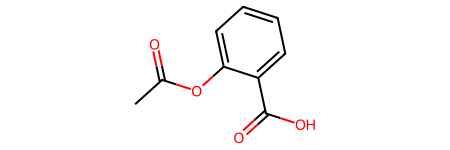

In [15]:
print(f"Name:\t{df.name[100]}\nSMILES:\t{df.smiles[100]}\nBBBP:\t{df.p_np[100]}")
molecule = molecule_from_smiles(df.iloc[100].smiles)
print("Molecule:")
molecule

In [16]:
graph = graph_from_molecule(molecule)
print("Graph (including self-loops):")
print("\tatom features\t", graph[0].shape)
print("\tbond features\t", graph[1].shape)
print("\tpair indices\t", graph[2].shape)

Graph (including self-loops):
	atom features	 (13, 29)
	bond features	 (39, 7)
	pair indices	 (39, 2)


In [17]:
def open_in_molview(smile: str) -> None:
    """ 
    Open the molecule in MolView.

    Parameters:
        smile (str): The SMILES representation of the molecule.
        
    Returns:
        None: Opens the molecule in MolView.
    """

    url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/cids/JSON"
    params = {"smiles": smile}
    response = requests.get(url, params=params)
    cid = response.json()["IdentifierList"]["CID"][0]
    molview_url = f"https://molview.org/?cid={cid}&classic=true"


    webbrowser.open(molview_url)


In [18]:

def plot_molecule_3d(smiles: str) -> None:
    """
    Generate a 3D plot of the molecule using Plotly.

    Parameters:
        smiles (str): The SMILES representation of the molecule.

    Returns:
        None: Displays the generated plot using Plotly.
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        AllChem.EmbedMolecule(mol)
        AllChem.UFFOptimizeMolecule(mol)

        atoms = mol.GetAtoms()
        coords = mol.GetConformer().GetPositions()
        bonds = mol.GetBonds()

        x, y, z = [], [], []
        for coord in coords:
            x.append(coord[0])
            y.append(coord[1])
            z.append(coord[2])

        atom_trace = go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode="markers",
            marker=dict(
                size=10,
                color=[atom.GetAtomicNum() for atom in atoms],
                colorscale="Viridis",
                opacity=0.8,
                colorbar=dict(title="Atomic Number"),
            ),
            text=[f'Atom {atom.GetSymbol()}' for atom in atoms],
        )

        x_lines, y_lines, z_lines = [], [], []
        for bond in bonds:
            start_idx = bond.GetBeginAtomIdx()
            end_idx = bond.GetEndAtomIdx()
            start_coord = coords[start_idx]
            end_coord = coords[end_idx]
            x_lines.extend([start_coord[0], end_coord[0], None])
            y_lines.extend([start_coord[1], end_coord[1], None])
            z_lines.extend([start_coord[2], end_coord[2], None])

        bond_trace = go.Scatter3d(
            x=x_lines,
            y=y_lines,
            z=z_lines,
            mode="lines",
            line=dict(color='rgb(125,125,125)', width=2),
        )

        fig = go.Figure(data=[atom_trace, bond_trace])

        fig.update_layout(
            title='3D Molecular Structure with Bonds',
            scene=dict(
                xaxis=dict(title='X Axis'),
                yaxis=dict(title='Y Axis'),
                zaxis=dict(title='Z Axis'),
                aspectratio=dict(x=1, y=1, z=1),
            ),
            margin=dict(l=0, r=0, b=0, t=40),
        )

        return fig.show()
    except:
        print("Error: Could not generate 3D plot due to lack of sleep.")


In [19]:
def plot3D(smile: str) -> None:
    """
    Generate a 3D plot of the molecule.

    Parameters:
        smile (str): The SMILES representation of the molecule.

    Returns:    
        None: Displays the generated plot using Plotly.
    """
    try:
        mol = Chem.MolFromSmiles(smile)
        AllChem.EmbedMolecule(mol)
        AllChem.MMFFOptimizeMolecule(mol)
        mb = Chem.MolToMolBlock(mol)
        p = py3Dmol.view(width=600, height=600)
        p.addModel(mb, 'sdf')
        p.setStyle({'stick':{}})
        p.setBackgroundColor('0xeeeeee')
        p.zoomTo()
        return p.show()
    except:
        print("Error: Could not generate 3D plot due to lack of sleep.")


Name of the molecule: fengabine

2D representation of the molecule:


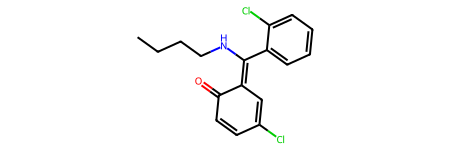

3D representation of the molecule (using Py3Dmol):


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

3D representation of the molecule (using Plotly):



Name of the molecule: benzoctamine

2D representation of the molecule:


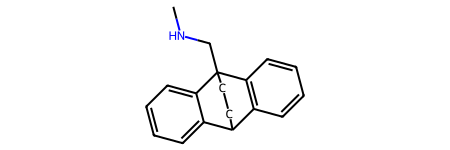

3D representation of the molecule (using Py3Dmol):


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

3D representation of the molecule (using Plotly):



Name of the molecule: Thiopental

2D representation of the molecule:


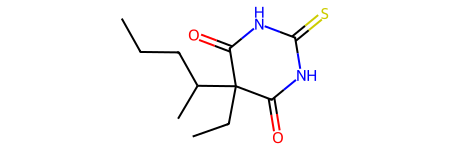

3D representation of the molecule (using Py3Dmol):


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

3D representation of the molecule (using Plotly):



Name of the molecule: BRL53087

2D representation of the molecule:


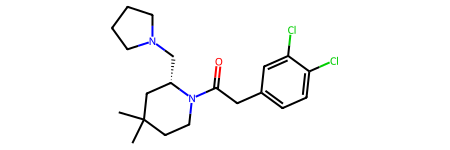

3D representation of the molecule (using Py3Dmol):


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

3D representation of the molecule (using Plotly):



Name of the molecule: savoxepin

2D representation of the molecule:


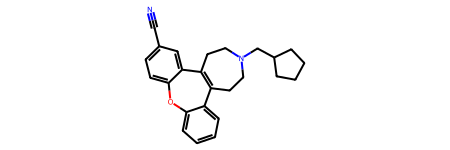

3D representation of the molecule (using Py3Dmol):


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

3D representation of the molecule (using Plotly):


In [20]:
random_smiles = df.sample(5).smiles.values
for smile in random_smiles:
    print(f'Name of the molecule: {df[df.smiles == smile].name.values[0]}')
    molecule = molecule_from_smiles(smile)
    print()
    print('2D representation of the molecule:')
    display(molecule)
    print('3D representation of the molecule (using Py3Dmol):')
    plot3D(smile)
    print('3D representation of the molecule (using Plotly):')
    plot_molecule_3d(smile)
    print()

In [21]:
def plotly_visualize_features(
                        feature_dict: dict, 
                        title: str, 
                        x_axis_title: str = "", 
                        y_axis_title: str = "Index"
                        ) -> None:
    """
    Generate a bar plot to visualize the distribution of the input data.

    Parameters:
        feature_dict (dict): The input data to be visualized.
        title (str): Title of the plot.
        x_axis_title (str, optional): Title for the x-axis. Defaults to "".
        y_axis_title (str, optional): Title for the y-axis. Defaults to "Index".

    Returns:
        None: Displays the generated plot using Plotly.
    """
    fig = go.Figure(
        go.Bar(
            x=list(feature_dict.keys()),
            y=list(feature_dict.values()),
            text=list(feature_dict.keys()),
            textposition="auto",
        )
    )
    fig.update_layout(
        title=title,
        xaxis_title=x_axis_title,
        yaxis_title=y_axis_title,
        font=dict(size=16),
        width=800,
        height=600,
    )
    fig.show()




In [22]:
plotly_visualize_features(atom_featurizer.features_mapping["symbol"], "Symbol Distribution", "Symbol", "Index")
plotly_visualize_features(atom_featurizer.features_mapping["hybridization"], "Hybridization Distribution", "Hybridization", "Index")
plotly_visualize_features(bond_featurizer.features_mapping["bond_type"], "Bond Type Distribution", "Bond Type", "Index")
plotly_visualize_features(bond_featurizer.features_mapping["conjugated"], "Conjugated Bond Distribution", "Conjugated", "Index")

In [23]:
def prepare_batch(x_batch: tuple, y_batch: np.ndarray) -> tuple:
    """
    Prepares a batch of data for training.

    Parameters:
        x_batch (tuple): A tuple containing the input data.
        y_batch (np.ndarray): The target data.

    Returns:
        tuple: A tuple containing the input data and the target data.
    """

    atom_features, bond_features, pair_indices = x_batch

    num_atoms = atom_features.row_lengths()
    num_bonds = bond_features.row_lengths()

    molecule_indices = tf.range(len(num_atoms))
    molecule_indicator = tf.repeat(molecule_indices, num_atoms)

    gather_indices = tf.repeat(molecule_indices[:-1], num_bonds[1:])
    increment = tf.cumsum(num_atoms[:-1])
    increment = tf.pad(tf.gather(increment, gather_indices), [(num_bonds[0], 0)])
    pair_indices = pair_indices.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    pair_indices = pair_indices + increment[:, tf.newaxis]
    atom_features = atom_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    bond_features = bond_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    return (atom_features, bond_features, pair_indices, molecule_indicator), y_batch



In [24]:
def MPNNDataset(X: tuple, y: np.ndarray, batch_size: int = 32, shuffle: bool = False) -> tf.data.Dataset:
    """
    Generates a tf.data.Dataset object for training.

    Parameters:
        X (tuple): A tuple containing the input data.
        y (np.ndarray): The target data.
        batch_size (int, optional): Batch size. Defaults to 32.
        shuffle (bool, optional): Whether to shuffle the data. Defaults to False.

    Returns:
        tf.data.Dataset: A tf.data.Dataset object for training.
    """
    dataset = tf.data.Dataset.from_tensor_slices((X, (y)))
    if shuffle:
        dataset = dataset.shuffle(1024)
    return dataset.batch(batch_size).map(prepare_batch, -1).prefetch(-1)

In [25]:
class EdgeNetwork(layers.Layer):
    def build(self: object, input_shape: tuple) -> None:
        """
        Builds the EdgeNetwork layer.

        Parameters:
            input_shape (tuple): Shape of the input tensor.

        Returns:
            None: Builds the EdgeNetwork layer.
        """

        self.atom_dim = input_shape[0][-1]
        self.bond_dim = input_shape[1][-1]
        self.kernel = self.add_weight(
            shape=(self.bond_dim, self.atom_dim * self.atom_dim),
            initializer="glorot_uniform",
            name="kernel",
        )
        self.bias = self.add_weight(
            shape=(self.atom_dim * self.atom_dim), initializer="zeros", name="bias",
        )
        self.built = True

    def call(self: object, inputs: tuple) -> tf.Tensor:
        """
        Executes the EdgeNetwork layer.

        Parameters:
            inputs (tuple): Tuple containing the input tensors.

        Returns:
            tf.Tensor: Output tensor.
        """

        atom_features, bond_features, pair_indices = inputs

        bond_features = tf.matmul(bond_features, self.kernel) + self.bias

        bond_features = tf.reshape(bond_features, (-1, self.atom_dim, self.atom_dim))

        atom_features_neighbors = tf.gather(atom_features, pair_indices[:, 1])
        atom_features_neighbors = tf.expand_dims(atom_features_neighbors, axis=-1)

        transformed_features = tf.matmul(bond_features, atom_features_neighbors)
        transformed_features = tf.squeeze(transformed_features, axis=-1)
        aggregated_features = tf.math.unsorted_segment_sum(
            transformed_features,
            pair_indices[:, 0],
            num_segments=tf.shape(atom_features)[0],
        )
        return aggregated_features



In [26]:
class MessagePassing(layers.Layer):
    def __init__(self: object, units: int, steps: int = 4, **kwargs) -> None:
        """
        Initializes the MessagePassing layer.

        Parameters:
            units (int): Dimensionality of the output space.
            steps (int, optional): Number of message passing steps. Defaults to 4.
            **kwargs: Additional keyword arguments.

        Attributes:
            units (int): Dimensionality of the output space.
            steps (int): Number of message passing steps.
            atom_dim (int): Dimensionality of the atom feature vector.
            message_step (EdgeNetwork): EdgeNetwork layer.
            pad_length (int): Padding length.
            update_step (GRUCell): GRUCell layer.
        """

        super().__init__(**kwargs)
        self.units = units
        self.steps = steps

    def build(self: object, input_shape: tuple) -> None:
        """
        Builds the MessagePassing layer.

        Parameters:
            input_shape (tuple): Shape of the input tensor.

        Returns:
            None: Builds the MessagePassing layer.
        """
        self.atom_dim = input_shape[0][-1]
        self.message_step = EdgeNetwork()
        self.pad_length = max(0, self.units - self.atom_dim)
        self.update_step = layers.GRUCell(self.atom_dim + self.pad_length)
        self.built = True

    def call(self: object, inputs: tuple) -> tf.Tensor:
        """
        Executes the MessagePassing layer.

        Parameters:
            inputs (tuple): Tuple containing the input tensors.

        Returns:
            tf.Tensor: Output tensor.
        """
        atom_features, bond_features, pair_indices = inputs
        atom_features_updated = tf.pad(atom_features, [(0, 0), (0, self.pad_length)])

        for i in range(self.steps):
            atom_features_aggregated = self.message_step(
                [atom_features_updated, bond_features, pair_indices]
            )

            atom_features_updated, _ = self.update_step(
                atom_features_aggregated, atom_features_updated
            )
        return atom_features_updated


In [27]:
class PartitionPadding(layers.Layer):
    def __init__(self: object, batch_size: int, **kwargs) -> None:
        """
        Initializes the PartitionPadding layer.

        Parameters:
            batch_size (int): Batch size.
            **kwargs: Additional keyword arguments.

        Attributes:
            batch_size (int): Batch size.
        """

        super().__init__(**kwargs)
        self.batch_size = batch_size

    def call(self: object, inputs: tuple) -> tf.Tensor:
        """
        Executes the PartitionPadding layer.

        Parameters:
            inputs (tuple): Tuple containing the input tensors. 

        Returns:
            tf.Tensor: Output tensor.
        """                 

        atom_features, molecule_indicator = inputs

        atom_features_partitioned = tf.dynamic_partition(
            atom_features, molecule_indicator, self.batch_size
        )

        num_atoms = [tf.shape(f)[0] for f in atom_features_partitioned]
        max_num_atoms = tf.reduce_max(num_atoms)
        atom_features_stacked = tf.stack(
            [
                tf.pad(f, [(0, max_num_atoms - n), (0, 0)])
                for f, n in zip(atom_features_partitioned, num_atoms)
            ],
            axis=0,
        )

        gather_indices = tf.where(tf.reduce_sum(atom_features_stacked, (1, 2)) != 0)
        gather_indices = tf.squeeze(gather_indices, axis=-1)
        return tf.gather(atom_features_stacked, gather_indices, axis=0)




In [28]:
class TransformerEncoderReadout(layers.Layer):
    def __init__(
        self: object, num_heads: int = 8, embed_dim: int = 64, dense_dim: int = 512, batch_size: int = 32, **kwargs
    ) -> None:
        """
        Initializes the TransformerEncoderReadout layer.

        Parameters:
            embed_dim (int, optional): Dimensionality of the output space. Defaults to 64.
            dense_dim (int, optional): Dimensionality of the dense layer. Defaults to 512.
            num_heads (int, optional): Number of attention heads. Defaults to 8.
            batch_size (int, optional): Batch size. Defaults to 32.
            **kwargs: Additional keyword arguments.

        Attributes:
            embed_dim (int): Dimensionality of the output space.
            dense_dim (int): Dimensionality of the dense layer.
            num_heads (int): Number of attention heads.
            batch_size (int): Batch size.
            partition_padding (PartitionPadding): PartitionPadding layer.
            attention (MultiHeadAttention): MultiHeadAttention layer.
            dense_proj (Sequential): Sequential dense layers.
            layernorm_1 (LayerNormalization): LayerNormalization layer.
            layernorm_2 (LayerNormalization): LayerNormalization layer.
            average_pooling (GlobalAveragePooling1D): GlobalAveragePooling1D layer.
        """
        super().__init__(**kwargs)

        self.partition_padding = PartitionPadding(batch_size)
        self.attention = layers.MultiHeadAttention(num_heads, embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.average_pooling = layers.GlobalAveragePooling1D()

    def call(self: object, inputs: tuple) -> tf.Tensor:
        """
        Executes the TransformerEncoderReadout layer.

        Parameters:
            inputs (tuple): Tuple containing the input tensors.

        Returns:
            tf.Tensor: Output tensor.
        """
        
        x = self.partition_padding(inputs)
        padding_mask = tf.reduce_any(tf.not_equal(x, 0.0), axis=-1)
        padding_mask = padding_mask[:, tf.newaxis, tf.newaxis, :]
        attention_output = self.attention(x, x, attention_mask=padding_mask)
        proj_input = self.layernorm_1(x + attention_output)
        proj_output = self.layernorm_2(proj_input + self.dense_proj(proj_input))
        return self.average_pooling(proj_output)

In [29]:
def MPNNModel(
    atom_dim : int,
    bond_dim : int,
    batch_size : int = 32,
    message_units : int = 64,
    message_steps : int = 4,
    num_attention_heads : int = 8,
    dense_units : int = 512,
) -> keras.Model:

    """
    Generates a MPNNModel model.

    Parameters:
        atom_dim (int): Dimensionality of the atom feature vector.
        bond_dim (int): Dimensionality of the bond feature vector.
        batch_size (int, optional): Batch size. Defaults to 32.
        message_units (int, optional): Dimensionality of the message passing units. Defaults to 64.
        message_steps (int, optional): Number of message passing steps. Defaults to 4.
        num_attention_heads (int, optional): Number of attention heads. Defaults to 8.
        dense_units (int, optional): Dimensionality of the dense layer. Defaults to 512.

    Returns:
        keras.Model: MPNNModel model.
    """

    atom_features = layers.Input((atom_dim), dtype="float32", name="atom_features")
    bond_features = layers.Input((bond_dim), dtype="float32", name="bond_features")
    pair_indices = layers.Input((2), dtype="int32", name="pair_indices")
    molecule_indicator = layers.Input((), dtype="int32", name="molecule_indicator")

    x = MessagePassing(message_units, message_steps)(
        [atom_features, bond_features, pair_indices]
    )

    x = TransformerEncoderReadout(
        num_attention_heads, message_units, dense_units, batch_size
    )([x, molecule_indicator])

    x = layers.Dense(dense_units, activation="relu")(x)
    x = layers.Dropout(0.2)(x) 
    x = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(
        inputs=[atom_features, bond_features, pair_indices, molecule_indicator],
        outputs=[x],
    )
    return model

In [30]:
mpnn = MPNNModel(
    atom_dim=x_train[0][0][0].shape[0], bond_dim=x_train[1][0][0].shape[0],
)

In [31]:
mpnn.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    metrics=[keras.metrics.AUC(name="AUC"), keras.metrics.BinaryAccuracy(name="ACC")],
)


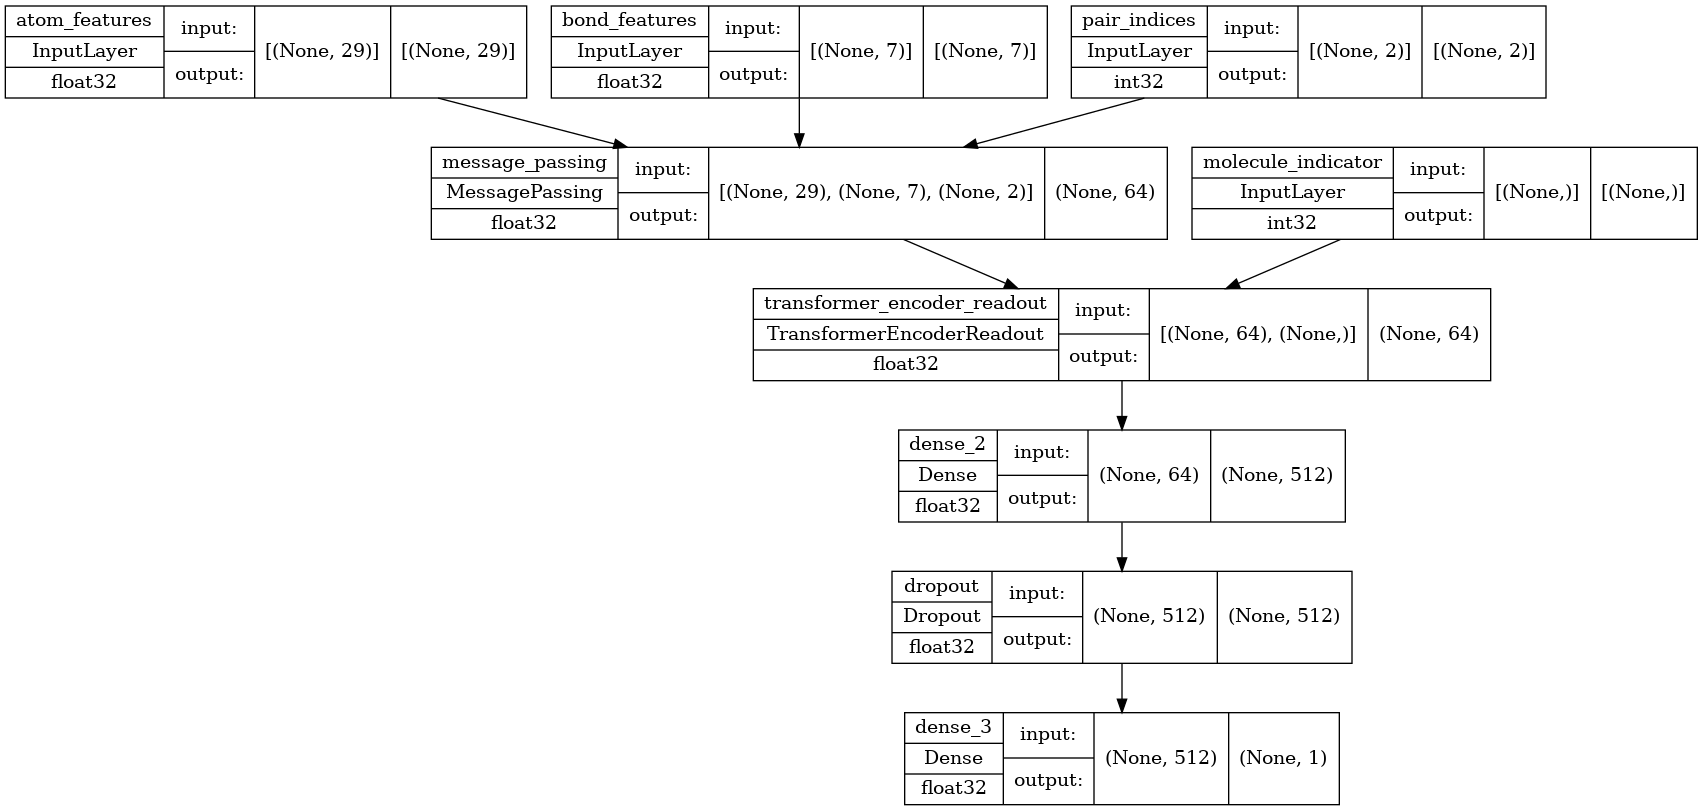

In [32]:
keras.utils.plot_model(mpnn, show_dtype=True, show_shapes=True)

In [33]:
train_dataset = MPNNDataset(x_train, y_train)
valid_dataset = MPNNDataset(x_valid, y_valid)
test_dataset = MPNNDataset(x_test, y_test)

In [34]:
history = mpnn.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=50,
    verbose=1,
    class_weight={0: 3.0, 1: 1}, 
)

Epoch 1/50
52/52 [==============================] - 22s 335ms/step - loss: 0.9470 - AUC: 0.6882 - ACC: 0.6805 - val_loss: 0.5246 - val_AUC: 0.8339 - val_ACC: 0.7481
Epoch 2/50
52/52 [==============================] - 15s 281ms/step - loss: 0.8294 - AUC: 0.7735 - ACC: 0.7573 - val_loss: 0.5021 - val_AUC: 0.8399 - val_ACC: 0.7918
Epoch 3/50
52/52 [==============================] - 14s 278ms/step - loss: 0.7914 - AUC: 0.7999 - ACC: 0.7848 - val_loss: 0.4860 - val_AUC: 0.8429 - val_ACC: 0.7995
Epoch 4/50
52/52 [==============================] - 14s 271ms/step - loss: 0.7769 - AUC: 0.8071 - ACC: 0.7957 - val_loss: 0.4459 - val_AUC: 0.8503 - val_ACC: 0.8123
Epoch 5/50
52/52 [==============================] - 14s 270ms/step - loss: 0.7609 - AUC: 0.8156 - ACC: 0.7921 - val_loss: 0.4156 - val_AUC: 0.8485 - val_ACC: 0.8406
Epoch 6/50
52/52 [==============================] - 14s 274ms/step - loss: 0.7481 - AUC: 0.8259 - ACC: 0.8067 - val_loss: 0.4732 - val_AUC: 0.8439 - val_ACC: 0.8098
Epoch 7/50

In [37]:
import pickle

filename = '../models/mpnn_model.sav'
pickle.dump(mpnn, open(filename, 'wb'))


INFO:tensorflow:Assets written to: ram://ad7a8bce-e732-4e33-b4a8-fa068a401f9e/assets


INFO:tensorflow:Assets written to: ram://ad7a8bce-e732-4e33-b4a8-fa068a401f9e/assets


In [38]:
def plotPerformance(metric: str) -> None:
    """
    Generate a plot of the model performance.

    Parameters:
        metric (str): The metric to plot.

    Returns:
        None: Displays the generated plot using Plotly.
    """
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=[0], y=[0], mode="markers", name="Train"))
    fig.add_trace(go.Scatter(x=[0], y=[0], mode="markers", name="Validation"))

    fig.add_trace(
        go.Scatter(
            x=history.epoch,
            y=history.history[f"{metric}"],
            mode="lines+markers",
            name="Train",
        )
    )

    fig.add_trace(
        go.Scatter(
            x=history.epoch,
            y=history.history[f"val_{metric}"],
            mode="lines+markers",
            name="Validation",
        )
    )


    fig.update_layout(
        title=f"Model {metric}",
        xaxis_title="Epoch",
        yaxis_title=f"{metric}",
        font=dict(size=16),
        width=800,
        height=600,
    )

    fig.show()

plotPerformance("loss")
plotPerformance("AUC")

